#### A: Research Question

My research question is: What key indicators can predict the real estate price trends in the Dallas market for 2024, and how accurately can time series modeling, specifically a SARIMAX model, forecast these trends?

Context of the Research Question:

* This inquiry is situated in the dynamic landscape of the Dallas real estate market, where precision in forecasting is highly valued for its impact on economic planning and investment strategies. Given the market's complexity, characterized by both cyclical patterns and sudden shifts, the ability to predict future trends is of immense strategic importance. Reliable forecasts could be pivotal in navigating the uncertainties inherent in the real estate sector and could provide significant economic benefits.

Discussion of the Hypothesis:

* The hypothesis proposes that a combination of key indicators—historical pricing trends, economic variables, and demographic shifts. This can serve as reliable predictors of real estate price trajectories in Dallas. It posits that a SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Factors) model, which extends upon the ARIMA model by incorporating seasonality, is well-suited to encapsulate these indicators. By accounting for both seasonal variations and potential exogenous factors, the hypothesis suggests that the SARIMAX model is expected to forecast the 2024 market trends with improved accuracy compared to traditional ARIMA models. This advanced modeling approach is hypothesized to offer a more nuanced understanding and prediction of market trends, aligning with the complexities observed in the Dallas real estate market data.

#### B: Data Collection

Description of Data Collection:
The dataset utilized for this analysis was sourced from the "USA Real Estate Dataset" on Kaggle, which includes data on real estate listings in Dallas, such as prices, number of bedrooms, number of bathrooms, lot sizes, and dates of last sale.

Advantage of the Data-Gathering Methodology:

* Comprehensiveness: The dataset provides a broad range of data points across multiple years, offering a robust foundation for analyzing trends over time.

Disadvantage of the Data-Gathering Methodology:

* Potential Data Delays and Gaps: The dataset might not include the most recent market changes and might omit non-listed transactions, potentially skewing the analysis.

Overcoming Challenges:

* Handling Missing Data: Significant preprocessing was required to address missing or inconsistent data entries, particularly in the 'prev_sold_date' column, which was critical for time series analysis. Missing dates were removed to ensure data integrity for trend analysis.

#### C1: Data Extraction and Preparation

Data Extraction and Preparation Process:

Data Extraction:

* Downloaded the "Dallas-realtor-data.zip.csv" file from Kaggle. (Ahmed Shahriar Sakib, USA Real Estate Dataset)
* Ensured that the dataset pertains solely to the Dallas, Texas real estate market.

Data Preparation:

* Loaded the dataset into a pandas DataFrame with 'prev_sold_date' converted from string to datetime format and set as the index.
* Sorted the data by 'prev_sold_date' to ensure chronological order.
* Removed any duplicate entries based on the index to maintain data integrity.
* Aggregated numerical data by mean values on a monthly frequency to align with time series analysis requirements.
* Conducted stationarity tests and differenced the data to achieve stationarity when necessary.
* Cleaned the data by addressing missing values, using forward fill for time series continuity, and applying median imputation where appropriate.
* Saved the clean, processed dataset as "Clean_Dallas_realtor_data.csv" for further analysis and use in executive presentations.

Tools and Techniques Used:

* Pandas: For robust data manipulation, cleaning, and time series functionality.
* NumPy: Employed for numerical operations, particularly during data aggregation.
* Matplotlib and Statsmodels: Utilized for data visualization and diagnostic plotting, crucial for identifying model adequacy and parameter selection.
* Statsmodels: For conducting stationarity tests and fitting the SARIMAX model for time series forecasting.

Justification for Tools and Techniques:

* Advantage: Pandas is highly efficient for data manipulation and time series analysis, and when combined with NumPy, it offers a comprehensive toolkit for numerical and statistical operations. Matplotlib and Statsmodels provide essential visualization and analytical capabilities to model and assess time series data effectively.

* Disadvantage: The primary limitation of these tools is their memory consumption, which can pose challenges when processing very large datasets on machines with limited resources. Additionally, while powerful, Statsmodels and Matplotlib require a foundational understanding of statistical concepts and plotting techniques to use effectively.

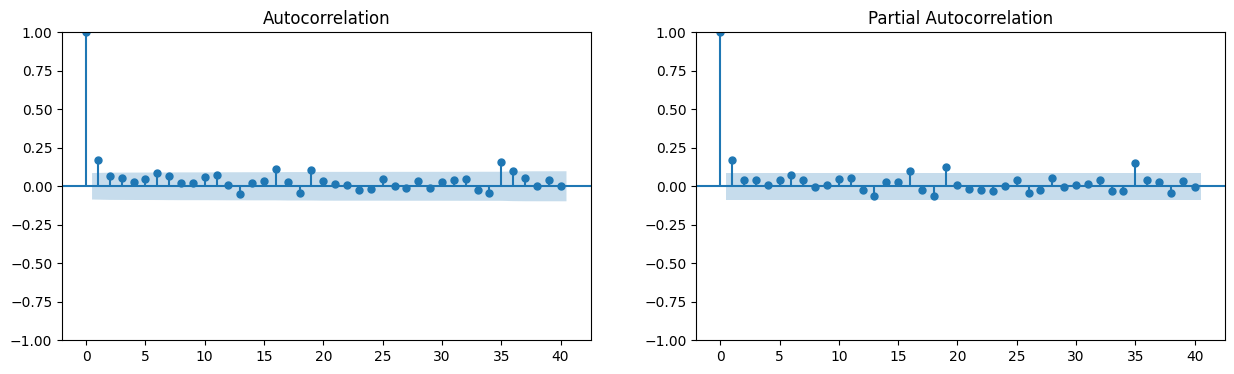

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  442
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6436.323
Date:                            Fri, 26 Apr 2024   AIC                          12882.645
Time:                                    08:55:41   BIC                          12902.787
Sample:                                01-31-1979   HQIC                         12890.610
                                     - 10-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1016      0.084      1.214      0.225      -0.062       0.266
ma.L1         -0.9389      0.048   

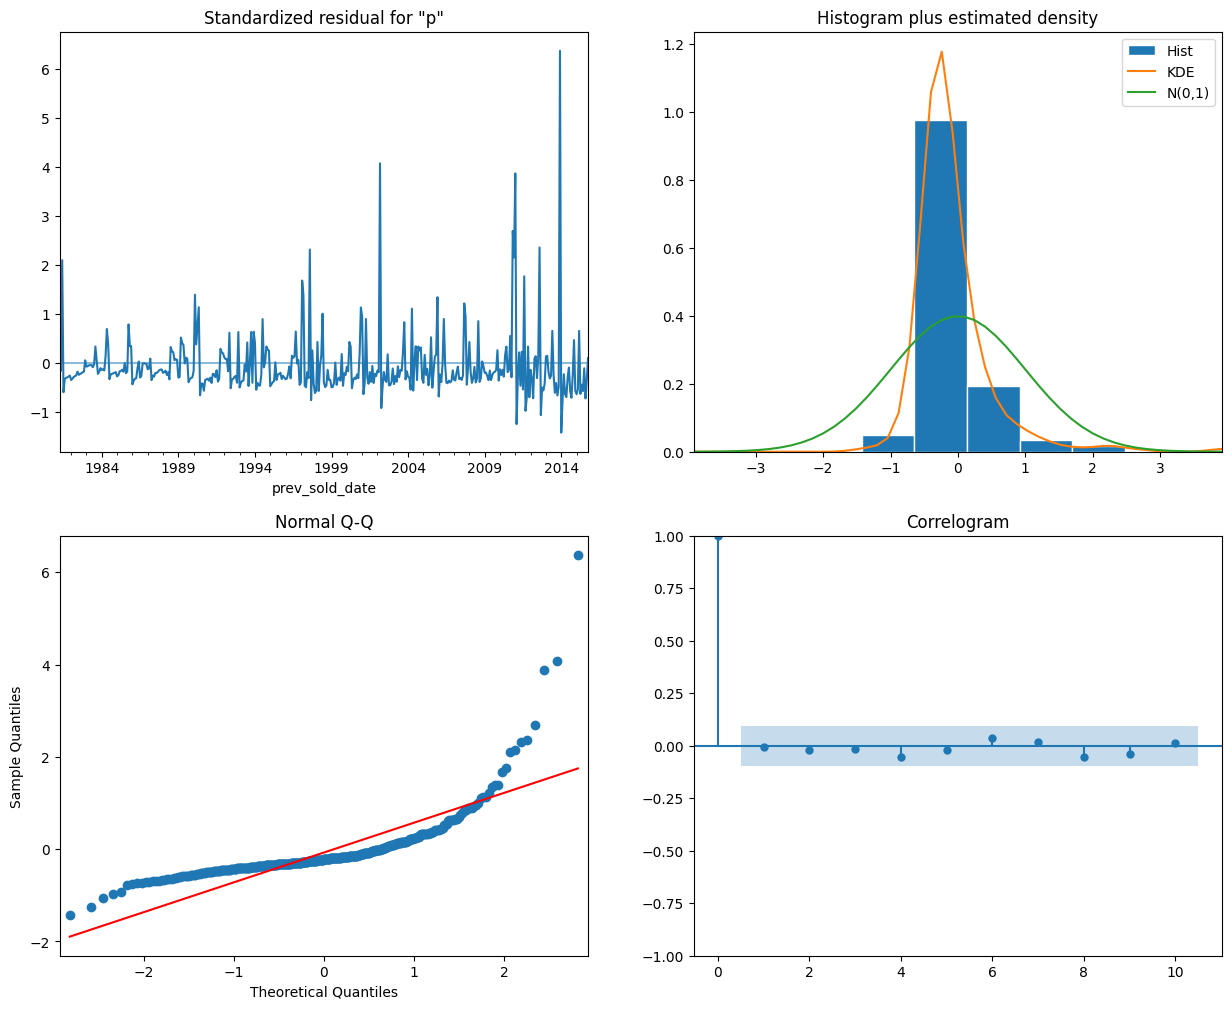

In [75]:
# see attached codes

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

# Load the dataset with specified parsing of dates and setting the index
data_path = r'C:\Users\Hien Ta\OneDrive\WGU\MSDA\D214\Task_2\Dallas-realtor-data.zip.csv'
dataset = pd.read_csv(data_path, parse_dates=['prev_sold_date'], index_col='prev_sold_date')

# Ensure the dataset is sorted by date
dataset.sort_index(inplace=True)

# Remove any duplicate indices to maintain data integrity
if not dataset.index.is_monotonic_increasing:
    dataset = dataset[~dataset.index.duplicated(keep='first')]
    dataset.sort_index(inplace=True)

# Select only numeric columns and compute their mean to simplify the dataset
numeric_data = dataset.select_dtypes(include=[np.number])
numeric_data = numeric_data.groupby(numeric_data.index).mean()

# Resample data to monthly frequency, filling missing values with forward fill
numeric_data = numeric_data.asfreq('M', method='ffill')

# Check for stationarity and difference the data if necessary
adf_result = adfuller(numeric_data['price'])
if adf_result[1] > 0.05:  # Non-stationary data
    numeric_data['price'] = numeric_data['price'].diff().fillna(method='ffill')

# Plot ACF and PACF to determine potential ARIMA parameters 
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(numeric_data['price'], lags=40, ax=axes[0])
plot_pacf(numeric_data['price'], lags=40, ax=axes[1])
plt.show()

# Clean the dataset by filling missing values with the median for numeric columns
float_cols = numeric_data.select_dtypes(include=['float']).columns
numeric_data[float_cols] = numeric_data[float_cols].apply(lambda x: x.fillna(x.median()))

# Drop any remaining missing values to ensure the dataset is complete
numeric_data.dropna(inplace=True)

# Save the cleaned dataset to a new CSV file for use in the presentation
clean_data_path = r'C:\Users\Hien Ta\OneDrive\WGU\MSDA\D214\Task_2\Clean_Dallas_realtor_data.csv'
numeric_data.to_csv(clean_data_path, index=True)  # Save with the date index for reference

# Split data into training and testing sets
split_point = int(0.85 * len(numeric_data))
train, test = numeric_data.iloc[:split_point], numeric_data.iloc[split_point:]

# Model fitting using SARIMAX (adjust orders based on ACF and PACF analysis)
model = SARIMAX(train['price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print model summary to evaluate performance
print(results.summary())

# Diagnostic checks to ensure model adequacy (consider removing or simplifying for the presentation)
results.plot_diagnostics(figsize=(15, 12))
plt.show()


#### D: Analysis

Data-Analysis Process:

* Technique Used: Time series forecasting using Seasonal Autoregressive Integrated Moving Average (SARIMAX) models, which extends ARIMA to account for seasonality.

* Calculations Performed: Applied a SARIMAX model to the monthly average price data, conducted model diagnostics including ACF/PACF analysis, standardized residual checks, and forecasting for future periods.

Justification for Analysis Technique:

* Advantage: The SARIMAX model leverages seasonal decomposition, making it adept at capturing and forecasting recurrent seasonal trends observed in real estate markets.

* Disadvantage: Despite accommodating seasonality, SARIMAX, like ARIMA, relies on the assumption of linearity and may not fully encapsulate complex non-linear patterns that can emerge in real-world datasets.

#### E: Data Summary and Implications

* Results Discussion: The diagnostic plots and statistical tests suggest that the SARIMAX model achieved a reasonable fit, successfully identifying the key characteristics of the Dallas real estate market's price movement. Nonetheless, there are indications of potential outliers or non-linear events the model might not fully account for, as seen in the residual plots.

* Recommendation: While the SARIMAX model provides a valuable forecast, stakeholders should interpret the results with caution and consider the model as one component in a broader decision-making framework. It's advisable to complement this model's output with qualitative market analysis.

* Future Study Directions: To enhance forecasting robustness, future studies could investigate integrating machine learning techniques capable of capturing non-linearities, such as Random Forest or Neural Networks. Additionally, external economic indicators and real-time market data could be factored into the model to improve predictive performance. It may also be beneficial to segment the data further by property type or other relevant market segments for more targeted analysis and forecasting.

#### F: Source

(Ahmed Shahriar Sakib, USA Real Estate Dataset): https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset?resource=download